In [66]:
# This is the main file that calls the functions to perform image stitching
import cv2
import skimage
import scipy
from skimage import io, filters
import numpy as np
from skimage import io, morphology, color, util
import matplotlib.pyplot as plt

### Compute Homography H

In [70]:
# This file contains the function that computes the homography between two images
def compute_homography(keypoint1, keypoint2):
    # perform Normalized Direct Linear Transformation on the keypoints

    print("Shape of keypoints 1: ", keypoint1.shape)
    print("Shape of keypoints 2: ", keypoint2.shape)
    num_of_kps = keypoint1.shape[0]

    print("Shape of op:", np.transpose(np.column_stack((keypoint1, np.ones(num_of_kps)))).shape)
    keypoint1_homogeneous = np.column_stack((keypoint1, np.ones(num_of_kps)))
    keypoint2_homogeneous = np.column_stack((keypoint2, np.ones(num_of_kps)))

    # create the A matrix for Ah = 0
    A = []
    for i in range(num_of_kps):
        x1, y1, _ = keypoint1_homogeneous[i]
        x2, y2, _ = keypoint2_homogeneous[i]
        A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
        A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    A = np.array(A)  # shape = 2N x 9
    # B = np.dot(np.transpose(A), A)  # B = A^T*A

    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))

    H = H / H[-1, -1]

    print('Final homography H:')
    print(H)

    return H

### Generate SIFT matches

In [73]:
# From OpenCV tutorial
def get_sift_points(query_img, train_img):
    img1 = cv2.imread(query_img, cv2.IMREAD_GRAYSCALE)  # queryImage
    img2 = cv2.imread(train_img, cv2.IMREAD_GRAYSCALE)  # trainImage
    img_color1 = cv2.imread(query_img, cv2.IMREAD_COLOR)  # queryImage
    img_color2 = cv2.imread(train_img, cv2.IMREAD_COLOR)  # trainImage
    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp_img, des1 = sift.detectAndCompute(img1, None)
    kp_stitch, des2 = sift.detectAndCompute(img2, None)
    
    ########### TEST 1 #############
    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append([m])

    points_query = np.float32([kp_img[m.queryIdx].pt for m, n in matches if m.distance < 0.75 * n.distance])
    points_train = np.float32([kp_stitch[m.trainIdx].pt for m, n in matches if m.distance < 0.75 * n.distance])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, kp_img, img2, kp_stitch, good, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    ########### TEST 2 (WITH RANSAC) ###########
    
    # MIN_MATCH_COUNT = 10
    # FLANN_INDEX_KDTREE = 1
    # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # search_params = dict(checks = 50)
    # flann = cv2.FlannBasedMatcher(index_params, search_params)
    # matches = flann.knnMatch(des1,des2,k=2)
    # # store all the good matches as per Lowe's ratio test.
    # good = []
    # for m,n in matches:
    #     if m.distance < 0.7*n.distance:
    #         good.append(m)
    # 
    # if len(good)>MIN_MATCH_COUNT:
    #     src_pts = np.float32([ kp_img[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    #     dst_pts = np.float32([ kp_stitch[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    #     M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    #     matchesMask = mask.ravel().tolist()
    #     h,w = img1.shape
    #     pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    #     dst = cv2.perspectiveTransform(pts,M)
    #     img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    # else:
    #     print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    #     matchesMask = None
    # 
    # draw_params = dict(matchColor = (0,255,0), # draw matches in green color
    #                    singlePointColor = None,
    #                    matchesMask = matchesMask, # draw only inliers
    #                    flags = 2)
    # img3 = cv2.drawMatches(img1,kp_img,img2,kp_stitch,good,None,**draw_params)
    # plt.imshow(img3, 'gray'),plt.show()
    
    ####### TEST 3 (not quite working) #########
    
    # # find the keypoints and descriptors with SIFT
    # kp_img, des1 = sift.detectAndCompute(img1, None)
    # kp_stitch, des2 = sift.detectAndCompute(img2, None)
    # 
    # # initialize the Brute Force matcher (BFMatcher)
    # bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # 
    # # match the descriptors
    # matches = bf.match(des1, des2)
    # 
    # # sort the matches based on distance
    # matches = sorted(matches, key = lambda x:x.distance)
    # img3 = cv2.drawMatches(img1, kp_img, img2, kp_stitch, matches[:300], None, flags=2)
    ############################
    
    plt.imshow(img3), plt.show()
    cv2.imwrite("matches.jpg", img3)

    # Convert kp object into numpy array
    kp_img_list = [kp.pt for kp in kp_img]
    kp_stitch_list = [kp.pt for kp in kp_stitch]
    
    kp_img_np = np.array(kp_img_list)
    kp_stitch_np = np.array(kp_stitch_list)
    
    return points_query, points_train

Test for the get sift points function

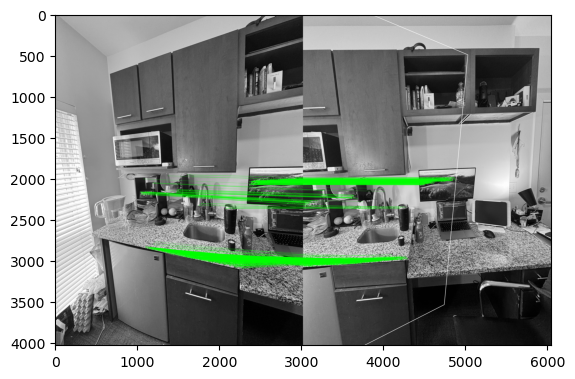

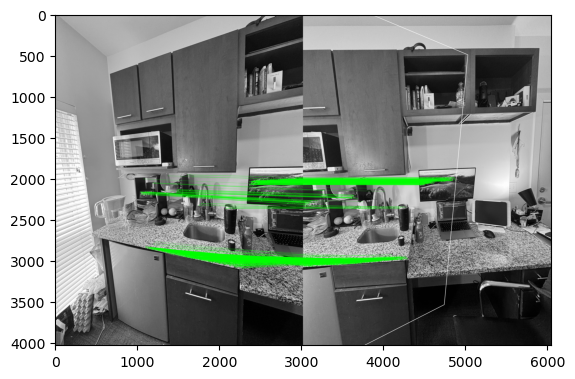

(63463, 2)


In [62]:
img1_path = "room_center.jpeg"
img2_path = "room_left.jpeg"
kp_pts, kp_im_pts = get_sift_points(img2_path, img1_path)
print(kp_pts.shape)

### Function for running RANSAC

In [74]:
# Functon runRANSAC: x_dest are the destination points, x_src are the points from source, ransac_itr is the number of iterations, threshold.
def run_ransac(x_src, x_dest, ransac_itr, threshold):
    # H, mask = cv2.findHomography(np.float32(kp_img), np.float32(kp_stitch), cv2.RANSAC, threshold)
    num_pts = len(x_src)
    pts_id = np.arange(num_pts)
    max_M = 0
    best_H = None
    inliers_id = np.array([])
    print("Keypoint shapes", x_src.shape, x_dest.shape)
    
    for iter in range(ransac_itr):
        inds = np.random.choice(num_pts, 4, replace=False)
        pts_src = x_src[inds, :]
        pts_dst = x_dest[inds, :]
        # Compute the homography matrix
        ######### USING CV2 ############
        # H, _ = cv2.findHomography(pts_src, pts_dst, method=cv2.RANSAC)
        ######## HW Homography Function ###########
        H = compute_homography(pts_src, pts_dst)
        # Project source points to destination using homography
        ones = np.ones((num_pts, 1))
        # Convert to homogenous coordinates
        x_src_homog = np.hstack((x_src, ones))
        projected_pts = H @ x_src_homog.T
        projected_pts /= projected_pts[2, :]  # Convert from homogenous to Cartesian coords
        # Calculate distances
        temp = projected_pts[:2, :].T
        print("Shape of temp:", temp.shape)
        print("Shape of x_dest:", x_dest.shape)
        dist = np.sqrt(np.sum((temp - x_dest) ** 2, axis=1))
        
        # Determine inliers
        i = dist < threshold
        num_inliers = np.sum(i)
        
        # Update best model if current model is better
        if num_inliers > max_M:
            max_M = num_inliers
            best_H = H
            inliers_id = np.where(i)[0]  # Store the indices of the inliers

    return inliers_id, best_H
        

Code to test the ransac script

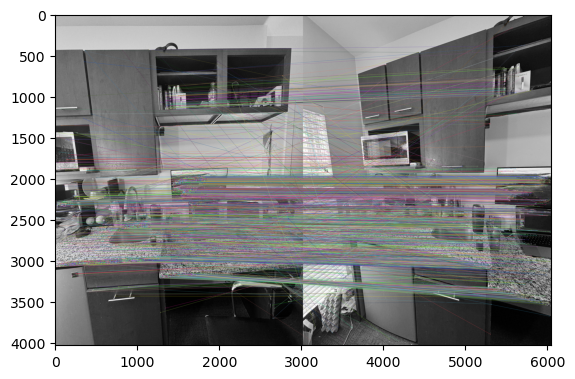

Keypoint shapes (3458, 2) (3458, 2)
Shape of keypoints 1:  (4, 2)
Shape of keypoints 2:  (4, 2)
Shape of op: (3, 4)
Final homography H:
[[-6.13591576e-01 -1.87138471e-01  1.28175298e+03]
 [-1.01160474e+00 -1.04307723e+00  3.89609372e+03]
 [-3.70741588e-04 -2.27764747e-04  1.00000000e+00]]
Shape of temp: (3458, 2)
Shape of x_dest: (3458, 2)
Shape of keypoints 1:  (4, 2)
Shape of keypoints 2:  (4, 2)
Shape of op: (3, 4)
Final homography H:
[[ 5.94941886e-01 -2.25132492e-01  4.36300494e+00]
 [-5.32143020e-02  8.93260620e-02  1.34344491e+03]
 [ 1.32354710e-05 -1.73149558e-04  1.00000000e+00]]
Shape of temp: (3458, 2)
Shape of x_dest: (3458, 2)
Shape of keypoints 1:  (4, 2)
Shape of keypoints 2:  (4, 2)
Shape of op: (3, 4)
Final homography H:
[[-1.24926857e+00 -4.47671089e-01  2.99342274e+03]
 [-8.01907561e-01 -9.48575146e-01  2.48441194e+03]
 [-4.36935497e-04 -2.79839712e-04  1.00000000e+00]]
Shape of temp: (3458, 2)
Shape of x_dest: (3458, 2)
Shape of keypoints 1:  (4, 2)
Shape of keypoin

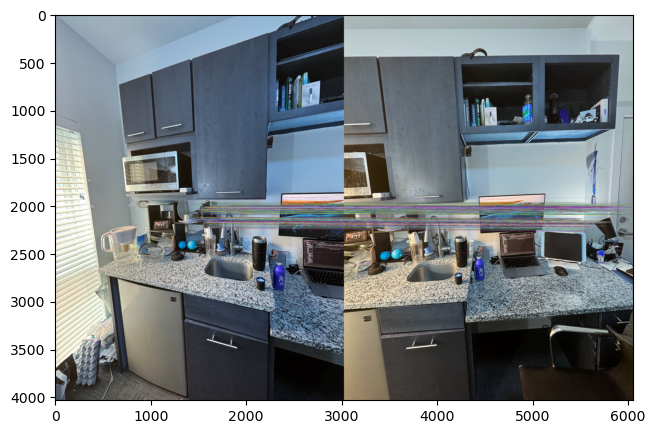

In [79]:
img1_path = "room_center.jpeg"
img2_path = "room_left.jpeg"
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
kp_stitched, kp_img = get_sift_points(img1_path, img2_path)
inliers_id, best_H = run_ransac(kp_img, kp_stitched, 300, 1)

def draw_matches(img1, kp_img, img2, kp_stitched, inliers):
    """
    Draws lines between matching keypoints of two images.
    Only inliers are drawn.
    img1, img2: source and destination images
    kp1, kp2: keypoints from both images
    inliers: array of indices of inliers to be drawn
    """
    # Create a blank image that fits both the input images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = (h1 - h2) // 2
    new_img = np.zeros((nHeight, nWidth, 3), dtype=np.uint8)
    new_img[hdif:hdif + h2, :w2] = img2
    new_img[:h1, w2:w1 + w2] = img1

    # Draw lines for inliers
    for i in inliers:
        pt1 = (int(kp_img[i][0] + w2), int(kp_img[i][1]))
        pt2 = (int(kp_stitched[i][0]), int(kp_stitched[i][1]) + hdif)
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.line(new_img, pt1, pt2, color, 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(new_img)
    cv2.imwrite("ransac.jpg", new_img)
    plt.show()

draw_matches(img1, kp_img, img2, kp_stitched, inliers_id)


### Image stitching main function

In [ ]:
def image_stitcher(*image_paths):
    images = [skimage.io.imread(path) for path in image_paths]
    # Display images
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for i, (img, path) in enumerate(zip(images, image_paths)):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(path)
    plt.show()
    # Get total number of vertical pixels
    y_stitched = sum(img.shape[0] for img in images)  # Sum of heights
    x_stitched = sum(img.shape[1] for img in images)  # Sum of widths
    channel_stitch = images[0].shape[2]  # Set the channel (color)

    # Create an array for the stitched image (initializing to 0)
    stitched_img = np.zeros((y_stitched, x_stitched, channel_stitch), dtype=images[0].dtype)
    num_images = len(images) - 1  # number of images to be stitched
    middle_img_idx = num_images // 2  # index of the center image

    # Setting the reference image (image to stitch around)
    ref_img = images[middle_img_idx]
    # Size of the ref image
    ref_img_height = ref_img.shape[0]
    ref_img_width = ref_img.shape[1]
    # Calculate the starting position  ensuring they fit within the dimensions of the stitched image (floor division is done using, //)
    ref_start_x = max(0, min((x_stitched - ref_img_width) // 2, x_stitched - ref_img_width))
    ref_start_y = max(0, min((y_stitched - ref_img_height) // 2, y_stitched - ref_img_height))
    # Initialize binary mask for tracking filled areas (0 is not filled, otherwise filled) and gets updated each time new area is filled
    stitch_mask = np.zeros((y_stitched, x_stitched))
    stitch_mask[ref_start_y:ref_start_y + ref_img_height, ref_start_x:ref_start_x + ref_img_width] = 1
    # Create the starting image stitch (starts with center image)
    stitched_img[ref_start_y:ref_start_y + ref_img_height, ref_start_x:ref_start_x + ref_img_width, :] = ref_img

    for idx, img in enumerate(images):
        # Skip past the middle image
        if idx == middle_img_idx:
            continue
        # Generate SIFT matches from indexed image and the current stitched image (Generates kp for stitched image and current image)
        kp_stitch, kp_img = get_sift_points(stitched_img, img)
        inliers_id, best_H = runRANSAC(kp_img, kp_stitch, 300, 1)
        
        
        
        


    return stitch_mask


# Testing images
img1_path = "room_left.jpeg"
img2_path = "room_center.jpeg"
img3_path = "room_right.jpeg"

result_img = image_stitcher(img1_path, img2_path, img3_path)
plt.imshow(result_img)
plt.axis('off')
plt.show()
